In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
# from imblearn.over_sampling import RandomOverSampler
from shapely.geometry import Point
import geopandas as gpd


# Show all rows in output
pd.set_option('display.max_rows', 1000)
# Show all columns in output
pd.set_option('display.max_columns', 200)

In [3]:
# Pobranie danych - merchants, users, transactions oraz geo_df - 
# geo_df - ifnromacje o miejscu (kraju transakcji), fladze country nan, odleglosc srodka ciezkosci kraju (merchant/user) od miejsca transakcji oraz wielkosc
# znormalizowana

merchants = pd.read_csv(r'../Data/merchants.csv')
users = pd.read_csv(r'../Data/users.csv')
transactions = pd.read_json(r'../Data/transactions.json', lines=True, dtype_backend="numpy_nullable")
geo_df = pd.read_csv(r'../geo_df.csv')

In [4]:
users.rename(columns={'country': 'country_users'}, inplace=True)
merchants = merchants.rename(columns={'country': 'country_merchant'})
# Merge transaction with merchant info
df_combined = transactions.merge(merchants, on='merchant_id', how='left')
# Merge result with user info
df_combined = df_combined.merge(users, on='user_id', how='left')
df_combined = df_combined.merge(geo_df, on='transaction_id', how='left')

In [5]:
df_combined['country_u=t'] = (df_combined.country_users == df_combined.transaction_country).astype(bool)
df_combined['country_m=t'] = (df_combined.country_merchant == df_combined.transaction_country).astype(bool)

In [6]:
def get_part_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    elif 21 <= hour < 23:
        return 'night'
    else:
        return 'late_night'
    
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Distance in kilometers

def flag_within_percent(df, amount_col='amount', user_col='user_id', tolerance_pct=10):
    """
    Flags if the current amount is within ±X% of the previous amount for each user.

    Parameters:
    - df: DataFrame
    - amount_col: column with amount values
    - user_col: column with user identifier
    - tolerance_pct: percent range to compare against

    Returns:
    - DataFrame with new binary column: f'within_{tolerance_pct}pct'
    """
    df = df.copy()
    flag_col = f'within_{tolerance_pct}pct'

    def process_group(group):
        prev_amt = group[amount_col].shift(1)
        lower = prev_amt * (1 - tolerance_pct / 100)
        upper = prev_amt * (1 + tolerance_pct / 100)
        flag = ((group[amount_col] >= lower) & (group[amount_col] <= upper)).astype(float)
        flag.iloc[0] = float('nan')  # first transaction per user
        return flag

    df[flag_col] = df.sort_values(by=['user_id', 'timestamp']).groupby(user_col, group_keys=False).apply(process_group)

    return df

In [7]:
df = df_combined

In [8]:
df

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country_users,signup_date,risk_score,transaction_country,is_country_nan,country_merchant_distance_centroid,country_user_distance_centroid,country_merchant_distance_centroid_w,country_user_distance_centroid_w,country_u=t,country_m=t
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0,travel,France,0.581711,3,74.97,23,1,23,Female,Bachelor,Savings,336.26,93.70,Sweden,2022-08-10,0.426675,NaN,True,1515.410581,2533.543004,0.241109,2.158806,False,False
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.0,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,1,32,1,0,electronics,Germany,0.568933,2,56.92,23,0,53,Female,PhD,Business,513.43,2047.83,France,2024-05-22,0.729627,Spain,False,1206.708668,372.009185,1.570350,0.059188,False,False
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,1,604,1,0,gaming,Denmark,0.608070,5,98.93,75,0,58,Female,Bachelor,Business,388.36,89.83,Italy,2021-05-18,0.393848,Poland,False,974.608451,1167.439535,3.133639,1.054413,False,False
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,0,1031,1,0,electronics,Portugal,0.592656,4,21.60,82,0,59,Male,Master,Employment,79.46,159.47,Portugal,2021-09-05,0.393405,NaN,True,1916.709682,1916.709682,4.336065,4.336065,False,False
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,1,330,0,0,gaming,Spain,0.450223,4,60.61,82,0,28,Female,PhD,Unemployment,444.06,4268.46,Austria,2023-06-01,0.524168,NaN,True,1582.705149,1099.620557,1.592936,2.539283,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,TX499995,2022-04-19 18:12:00,U00062,M0079,11.53,in-store,EUR,iOS,"{'lat': 65.503521, 'long': 13.05648}",bank_transfer,1,916,1,0,travel,Sweden,0.295231,0,1.26,12,1,50,Male,Bachelor,Employment,65.16,1538.11,Poland,2021-09-08,0.514065,Norway,False,345.477943,1528.645097,0.294378,2.222569,False,False
499996,TX499996,2023-06-02 06:59:00,U17320,M0760,78.01,mobile,EUR,iOS,"{'lat': 48.568223, 'long': -7.713759}",bank_transfer,1,527,0,0,restaurants,Italy,0.700921,1,40.48,33,0,35,Female,High School,Employment,131.01,424.92,Poland,2022-10-28,0.508625,NaN,True,1670.598956,1951.515954,1.508858,2.837401,False,False
499997,TX499997,2022-08-06 13:14:00,U07750,M0215,77.65,in-store,EUR,iOS,"{'lat': 46.172673, 'long': 35.355061}",bank_transfer,1,351,0,0,education,Spain,0.797026,4,15.81,111,1,37,Female,Bachelor,Savings,393.12,244.94,Czech Republic,2023-10-26,0.592257,NaN,True,3196.611621,NaN,3.217276,NaN,False,False
499998,TX499998,2023-03-20 22:00:00,U14492,M0848,221.38,online,EUR,iOS,"{'lat': 65.904775, 'long': 28.680062}",mobile_payment,1,887,0,0,electronics,Netherlands,1.000000,7,38.62,7,1,22,Male,High School,Student Aid,484.67,439.71,Ireland,2024-12-02,0.419711,Finland,False,1990.788817,2457.186511,7.017185,7.466771,False,False


In [9]:
def data_transform(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['Month_Year_EOM'] = (df['timestamp'] + pd.offsets.MonthEnd(0)).dt.date
    df['Date'] = df['timestamp'].dt.strftime('%d-%m-%Y')
    df['Year'] = df['timestamp'].dt.strftime('%Y')
    df['hour'] = df['timestamp'].dt.hour
    df['part_of_day'] = df['hour'].apply(get_part_of_day)

    df = df.sort_values(['user_id', 'timestamp'])

    # Create the driver: time difference from previous timestamp per user
    df['time_diff'] = df.groupby('user_id')['timestamp'].diff()
    df['time_diff_hours'] = (df['time_diff'].dt.total_seconds() / 3600).round(2)
    df['latitude'] = df['location'].apply(lambda x: x.get('lat')).round(2)
    df['longitude'] = df['location'].apply(lambda x: x.get('long')).round(2)

    df = df.sort_values(['user_id', 'timestamp'])

    # Shift lat, lon, and timestamp within each user
    df['lat_prev'] = df.groupby('user_id')['latitude'].shift()
    df['lon_prev'] = df.groupby('user_id')['longitude'].shift()
    df['time_prev'] = df.groupby('user_id')['timestamp'].shift()

    # Calculate time difference in hours
    df['time_diff_hours'] = (df['timestamp'] - df['time_prev']).dt.total_seconds() / 3600

    # Calculate distance (only between consecutive positions of the same user)
    df['distance_km'] = haversine(df['lat_prev'], df['lon_prev'], df['latitude'], df['longitude'])

    # Optional: speed in km/h
    df['speed_kmph'] = df['distance_km'] / df['time_diff_hours']
    df['amount/avg_amount'] = df['amount'] / df['avg_transaction_amount']
    df['amount/sum_monthly_installments'] = df['amount'] / df['sum_of_monthly_installments']
    df['amount/sum_monthly_expenses'] = df['amount'] / df['sum_of_monthly_expenses']
    df['speed_kmph'] = df['speed_kmph'].clip(upper=2000)
    df['countries_same'] = (df['country_merchant'] == df['country_users']).astype(int)


    # Ensure datetime and sort
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['user_id', 'timestamp'])


    df = flag_within_percent(df, amount_col='amount', user_col='user_id', tolerance_pct=10)
    df = flag_within_percent(df, amount_col='amount', user_col='user_id', tolerance_pct=5)



    # # Define time windows
    # window_durations = {
    #     # 'tx_last_12h': pd.Timedelta(hours=12),
    #     # 'tx_last_72h': pd.Timedelta(hours=72),
    #     'tx_last_240h': pd.Timedelta(hours=240)
    # }

    # rows = []

    # # Process per user
    # for user_id, group in df.groupby('user_id'):
    #     group = group.copy()
    #     for i, row in group.iterrows():
    #         current_time = row['timestamp']
    #         past = group[group['timestamp'] < current_time]
    #         feature_row = {'user_id': user_id, 'timestamp': current_time}
            
    #         for col, delta in window_durations.items():
    #             count = past[past['timestamp'] >= current_time - delta].shape[0]
    #             feature_row[col] = count

    #         rows.append(feature_row)

    # # Create final table
    # df_tx_counts = pd.DataFrame(rows)



    # # Merge safely
    # df_final = df.merge(df_tx_counts, on=['user_id', 'timestamp'], how='left')


    


    return df

In [10]:
df = data_transform(df)

C:\Users\Janek\AppData\Local\Temp\ipykernel_21156\1768709569.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[flag_col] = df.sort_values(by=['user_id', 'timestamp']).groupby(user_col, group_keys=False).apply(process_group)
C:\Users\Janek\AppData\Local\Temp\ipykernel_21156\1768709569.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[flag_col] = df.sort_values(by=['user_id', 'timestamp']).groupby

In [11]:
df

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country_users,signup_date,risk_score,transaction_country,is_country_nan,country_merchant_distance_centroid,country_user_distance_centroid,country_merchant_distance_centroid_w,country_user_distance_centroid_w,country_u=t,country_m=t,Month_Year_EOM,Date,Year,hour,part_of_day,time_diff,time_diff_hours,latitude,longitude,lat_prev,lon_prev,time_prev,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same,within_10pct,within_5pct
290822,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,"{'lat': 69.291741, 'long': -7.72625}",debit_card,1,811,0,0,grocery,Belgium,0.631421,2,26.85,37,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,NaN,True,2177.313231,1555.291561,9.069727,1.768340,False,False,2022-01-31,08-01-2022,2022,10,morning,NaT,NaN,69.29,-7.73,NaN,NaN,NaT,NaN,NaN,0.710987,0.039963,0.078502,0,NaN,NaN
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,1,233,1,0,gaming,Spain,0.859810,2,197.43,115,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,NaN,True,2129.369397,1247.193753,2.143134,1.418038,False,False,2022-01-31,08-01-2022,2022,16,afternoon,0 days 06:45:00,6.750000,54.71,15.37,69.29,-7.73,2022-01-08 10:03:00,1994.074291,295.418413,0.163298,0.067491,0.132577,0,0.0,0.0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,1,521,1,0,grocery,Spain,0.934815,5,18.36,68,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,Russia,False,3142.670637,659.904076,3.162986,0.750300,False,False,2022-01-31,12-01-2022,2022,16,afternoon,3 days 23:35:00,95.583333,58.90,30.26,54.71,15.37,2022-01-08 16:48:00,1016.169374,10.631240,0.23366,0.008981,0.017641,0,0.0,0.0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,1,1149,0,0,gaming,Belgium,0.859404,6,123.91,94,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,NaN,True,888.049093,2810.974138,3.699221,3.196029,False,False,2022-01-31,18-01-2022,2022,10,morning,5 days 18:17:00,138.283333,42.68,3.84,58.90,30.26,2022-01-12 16:23:00,2556.977104,18.490855,0.540715,0.140258,0.275516,0,0.0,0.0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,1,261,1,0,clothing,Germany,0.516453,1,0.98,52,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,Croatia,False,862.694031,2342.044995,1.122667,2.662865,False,False,2022-07-31,18-07-2022,2022,8,morning,180 days 21:25:00,4341.416667,44.30,15.75,42.68,3.84,2022-01-18 10:40:00,976.612531,0.224952,3.663265,0.007515,0.014763,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263172,TX263172,2023-08-16 08:18:00,U20000,M0426,35.83,in-store,EUR,iOS,"{'lat': 58.083086, 'long': 36.673547}",debit_card,1,967,0,0,restaurants,Netherlands,0.915723,7,158.60,15,1,50,Female,NaN,Unemployment,52.07,211.52,Ireland,2022-08-26,0.607373,Russia,False,2064.708109,2812.067294,7.277737,8.545164,False,False,2023-08-31,16-08-2023,2023,8,morning,50 days 10:00:00,1210.000000,58.08,36.67,37.04,9.07,2023-06-26 22:18:00,3081.342531,2.546564,0.225914,0.688112,0.169393,0,0.0,0.0
360206,TX360206,2023-08-28 07:39:00,U20000,M0487,21.69,mobile

In [13]:
print(list(df.columns.values))

['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'location', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'category', 'country_merchant', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'country_users', 'signup_date', 'risk_score', 'transaction_country', 'is_country_nan', 'country_merchant_distance_centroid', 'country_user_distance_centroid', 'country_merchant_distance_centroid_w', 'country_user_distance_centroid_w', 'country_u=t', 'country_m=t', 'Month_Year_EOM', 'Date', 'Year', 'hour', 'part_of_day', 'time_diff', 'time_diff_hours', 'latitude', 'longitude', 'lat_prev', 'lon_prev', 'time_prev', 'distance_km', 'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_e

In [26]:
# Get index of earliest timestamp for each user_id
first_idx = df.sort_values(by=['user_id', 'timestamp']).groupby('user_id').head(1).index


# Drop those rows
df = df.drop(index=first_idx)


In [27]:

test_df = df
to_drop = ['transaction_id', 'user_id', 'currency' , 'location']
numeric = ['amount', 'is_international', 'session_length_seconds' , 'is_first_time_merchant', 'trust_score', 'number_of_alerts_last_6_months',
           'avg_transaction_amount', 'account_age_months' ,'age', 'sum_of_monthly_installments', 'sum_of_monthly_expenses',
           'risk_score', 'time_diff_hours', 'distance_km', 'has_fraud_history', 
           'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 'hour', 'speed_kmph', 'countries_same',
           'tx_last_15min_y', 'tx_last_1h_y', 'tx_last_6h_y', 'tx_last_12h_y', 'is_country_nan', 'country_merchant_distance_centroid',
           'country_user_distance_centroid', 'country_merchant_distance_centroid_w', 'country_user_distance_centroid_w', 'country_u=t', 'country_m=t'
           ] 
to_categorize = ['channel', 'device', 'payment_method' , 'category', 'country_merchant', 'sex', 
                 'education', 'primary_source_of_income', 'country_users', 'part_of_day', 'transaction_country'
                 
                   ]
to_think_but_drop = ['signup_date', 'Month_Year_EOM', 'Date', 'Year', 'time_diff', 'time_prev' , 'latitude', 'longitude' ,'lat_prev', 'lon_prev', 
                     ]
target = 'is_fraud'

df = df.drop(to_drop, axis = 1)
df = df.drop(to_think_but_drop, axis =1 )
df = pd.get_dummies(df, columns=to_categorize)
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

In [28]:
cutoff = pd.to_datetime('2023-07-01')

# Split the data
df_train = df[df['timestamp'] < cutoff]
df_test = df[df['timestamp'] >= cutoff]
df_train = df_train.drop('timestamp', axis = 1 )
df_test = df_test.drop('timestamp', axis = 1 )
X_train = df_train.drop('is_fraud', axis = 1 )
y_train = df_train['is_fraud']
X_test = df_test.drop('is_fraud', axis = 1 )
y_test = df_test['is_fraud']

In [29]:
bad_rate_per_merchant = (
    df.groupby('merchant_id')['is_fraud']
    .agg(total_transactions='count', num_frauds='sum')
)
bad_rate_per_merchant['bad_rate'] = (
    bad_rate_per_merchant['num_frauds'] / bad_rate_per_merchant['total_transactions']
)

X_train = X_train.merge(bad_rate_per_merchant, on='merchant_id', how='left')
X_test = X_test.merge(bad_rate_per_merchant, on='merchant_id', how='left')

X_train = X_train.drop(['merchant_id','total_transactions','num_frauds'], axis = 1)
X_test = X_test.drop(['merchant_id','total_transactions','num_frauds'], axis = 1)

In [30]:
# Dodac rozklad w ciagu dnia fradulent percent
# + monthly
# + dodac kraj transakcji na podstawie long i latt
# +Dodac zmienna ile transakcji w ciagu ostatniej 1h, 6h 
# Dodac zmienna jesli obecna transakcja = wczesniejsza transakcja +-10%, +-5% itd (ile takich transakcji w np. 3h )
# Procentowa róznica wartosci obecnej transakcji w kontekscie do ostatniej (sredniej z ostatnich n transakcji) 


In [31]:
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

In [32]:
# mozna dodac scale _pos_weight option
y_test.value_counts()

is_fraud
0    115152
1     10791
Name: count, dtype: Int64

In [33]:
X_train_oversampled


,amount,is_international,session_length_seconds,is_first_time_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,is_country_nan,country_merchant_distance_centroid,country_user_distance_centroid,country_merchant_distance_centroid_w,country_user_distance_centroid_w,country_u=t,country_m=t,hour,time_diff_hours,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same,within_10pct,within_5pct,channel_in-store,channel_mobile,channel_online,device_Android,device_Web,device_iOS,payment_method_bank_transfer,payment_method_credit_card,payment_method_debit_card,payment_method_mobile_payment,category_clothing,category_education,category_electronics,category_gaming,category_grocery,category_restaurants,category_travel,country_merchant_Austria,country_merchant_Belgium,country_merchant_Czech Republic,country_merchant_Denmark,country_merchant_Finland,country_merchant_France,country_merchant_Germany,country_merchant_Ireland,country_merchant_Italy,country_merchant_Netherlands,country_merchant_Poland,country_merchant_Portugal,country_merchant_Spain,country_merchant_Sweden,sex_Female,sex_Male,sex_Other,education_Bachelor,education_High School,education_Master,education_PhD,primary_source_of_income_Business,primary_source_of_income_Employment,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment,country_users_Austria,country_users_Belgium,country_users_Czech Republic,country_users_Denmark,country_users_Finland,country_users_France,country_users_Germany,country_users_Ireland,country_users_Italy,country_users_Netherlands,country_users_Poland,country_users_Portugal,country_users_Spain,country_users_Sweden,part_of_day_afternoon,part_of_day_evening,part_of_day_late_night,part_of_day_morning,part_of_day_night,transaction_country_Albania,transaction_country_Algeria,transaction_country_Austria,transaction_country_Belarus,transaction_country_Belgium,transaction_country_Bosnia and Herz.,transaction_country_Bulgaria,transaction_country_Croatia,transaction_country_Cyprus,transaction_country_Czechia,transaction_country_Denmark,transaction_country_Estonia,transaction_country_Finland,transaction_country_France,transaction_country_Georgia,transaction_country_Germany,transaction_country_Greece,transaction_country_Hungary,transaction_country_Ireland,transaction_country_Italy,transaction_country_Kosovo,transaction_country_Latvia,transaction_country_Lithuania,transaction_country_Luxembourg,transaction_country_Moldova,transaction_country_Montenegro,transaction_country_Morocco,transaction_country_N. Cyprus,transaction_country_Netherlands,transaction_country_North Macedonia,transaction_country_Norway,transaction_country_Poland,transaction_country_Portugal,transaction_country_Romania,transaction_country_Russia,transaction_country_Serbia,transaction_country_Slovakia,transaction_country_Slovenia,transaction_country_Spain,transaction_country_Sweden,transaction_country_Switzerland,transaction_country_Syria,transaction_country_Tunisia,transaction_country_Turkey,transaction_country_Ukraine,transaction_country_United Kingdom,bad_rate
0,32.24,1,233,1,0.859810,2,197.43,115,1,56,477.69,243.18,0.571079,1,2129.369397,1247.193753,2.143134,1.418038,0,0,16,6.750000,1994.074291,295.418413,0.163298,0.067491,0.132577,0,0.0,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.092077
1,4.29,1,521,1,0.934815,5,18.36,68,0,56,477.69,243.18,0.571079,0,3142.670637,659.904076,3.162986,0.750300,0,0,16,95.583333,1016.169374,10.631240,0.23366,0.008981,0.017641,0,0.0,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0

In [54]:
# 2. Train XGBoost
model = XGBClassifier(
    n_estimators=1250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_alpha=1,         # L1 regularization
    reg_lambda=1,       # L2 regularization
    use_label_encoder=False,   
    eval_metric='auc',
    random_state=42
)

model.fit(
    X_train_oversampled, y_train_oversampled
)


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1250,
              n_jobs=None, num_parallel_tree=None, ...)

ROC AUC Score (Test): 0.5633
ROC AUC Score (Train): 0.8383
ROC AUC Score (Train on original): 0.8260


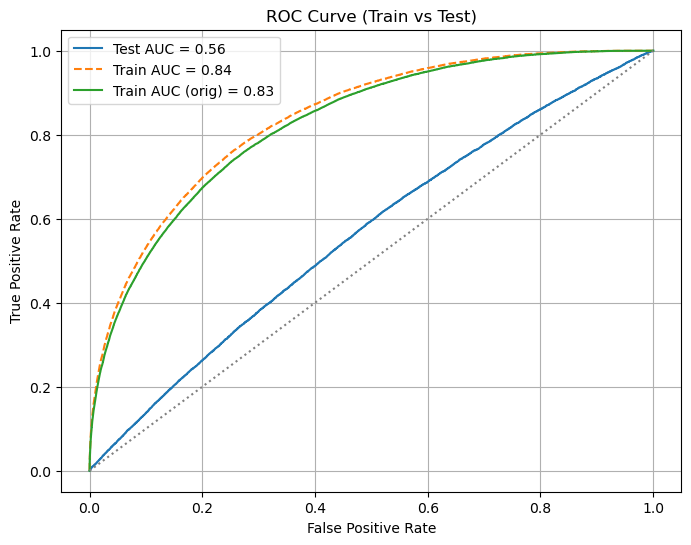

In [55]:
y_proba_test = model.predict_proba(X_test)[:, 1]
y_proba_train = model.predict_proba(X_train_oversampled)[:, 1]
y_proba_train_orig = model.predict_proba(X_train)[:, 1]  # <-- original X_train before oversampling

# Calculate AUC scores
auc_test = roc_auc_score(y_test, y_proba_test)
auc_train = roc_auc_score(y_train_oversampled, y_proba_train)
auc_train_orig = roc_auc_score(y_train, y_proba_train_orig)

print(f"ROC AUC Score (Test): {auc_test:.4f}")
print(f"ROC AUC Score (Train): {auc_train:.4f}")
print(f"ROC AUC Score (Train on original): {auc_train_orig:.4f}")

# Get ROC curve values
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train_oversampled, y_proba_train)
fpr_train_orig, tpr_train_orig, _ = roc_curve(y_train, y_proba_train_orig)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}', linestyle='--')
plt.plot(fpr_train_orig, tpr_train_orig, label=f'Train AUC (orig) = {auc_train_orig:.2f}', linestyle='-')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train vs Test)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
def plot_predicted_proba_by_class(y_true, y_pred_proba, bins=50):
    """
    Plots histogram of predicted probabilities split by actual class (y=0 vs y=1).

    Parameters:
    - y_true: array-like, true binary labels (0 or 1)
    - y_pred_proba: array-like, predicted probabilities for class 1
    - bins: number of histogram bins
    """
    plt.figure(figsize=(10, 6))
    
    # Separate predicted probabilities by actual class
    plt.hist(y_pred_proba[y_true == 0], bins=bins, alpha=0.6, label='y = 0', color='blue', density=True)
    plt.hist(y_pred_proba[y_true == 1], bins=bins, alpha=0.6, label='y = 1', color='red', density=True)
    
    plt.title('Histogram of Predicted Probabilities by True Class')
    plt.xlabel('Predicted Probability (class 1)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

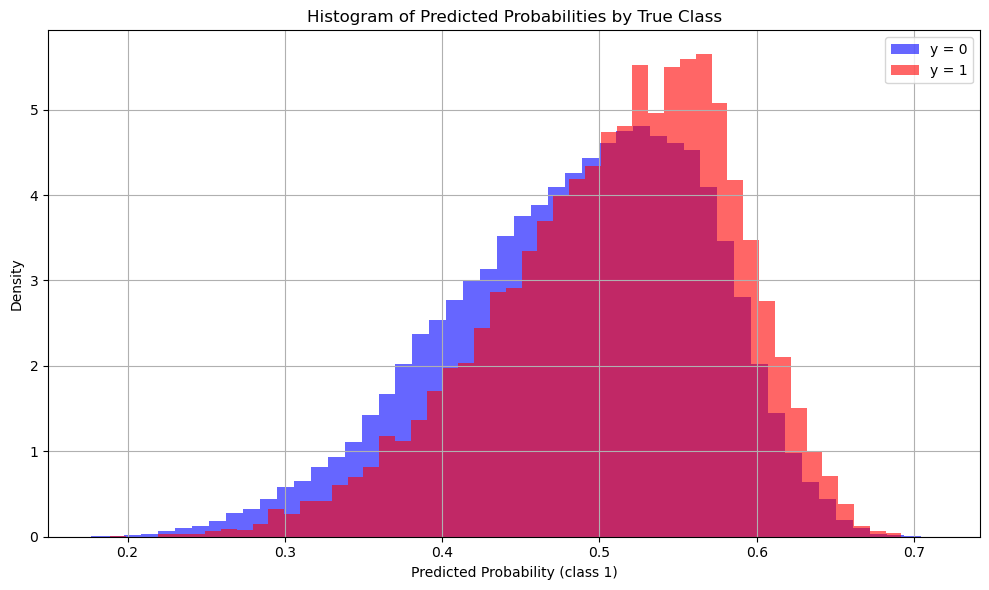

In [37]:
plot_predicted_proba_by_class(y_test, y_proba_test)

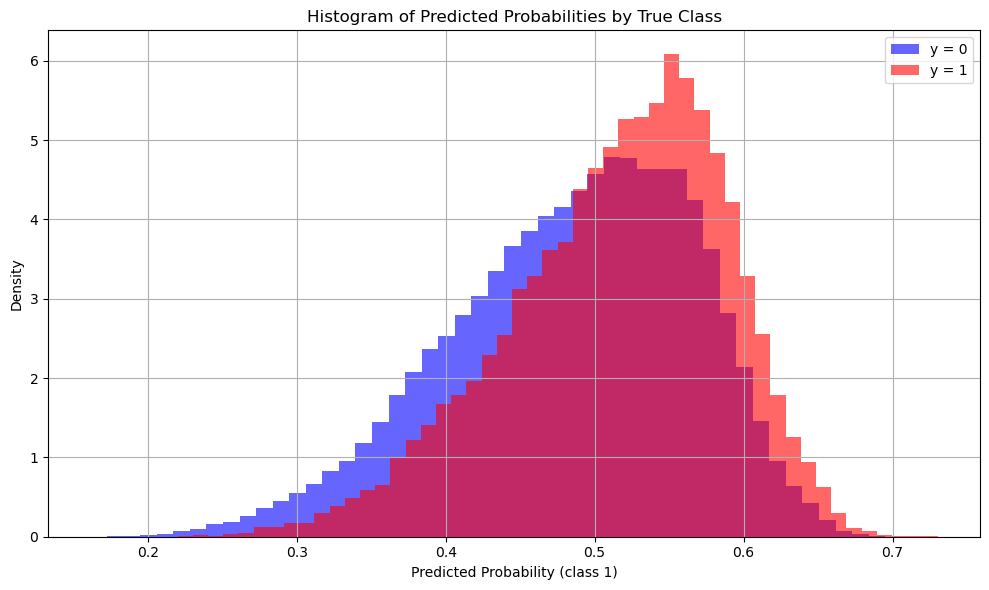

In [38]:
plot_predicted_proba_by_class(y_train, y_proba_train_orig)

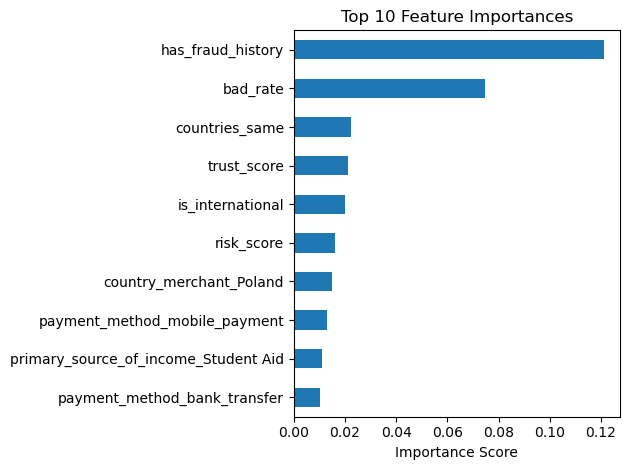

In [39]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10)

top_10_features.plot(kind='barh', title='Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)



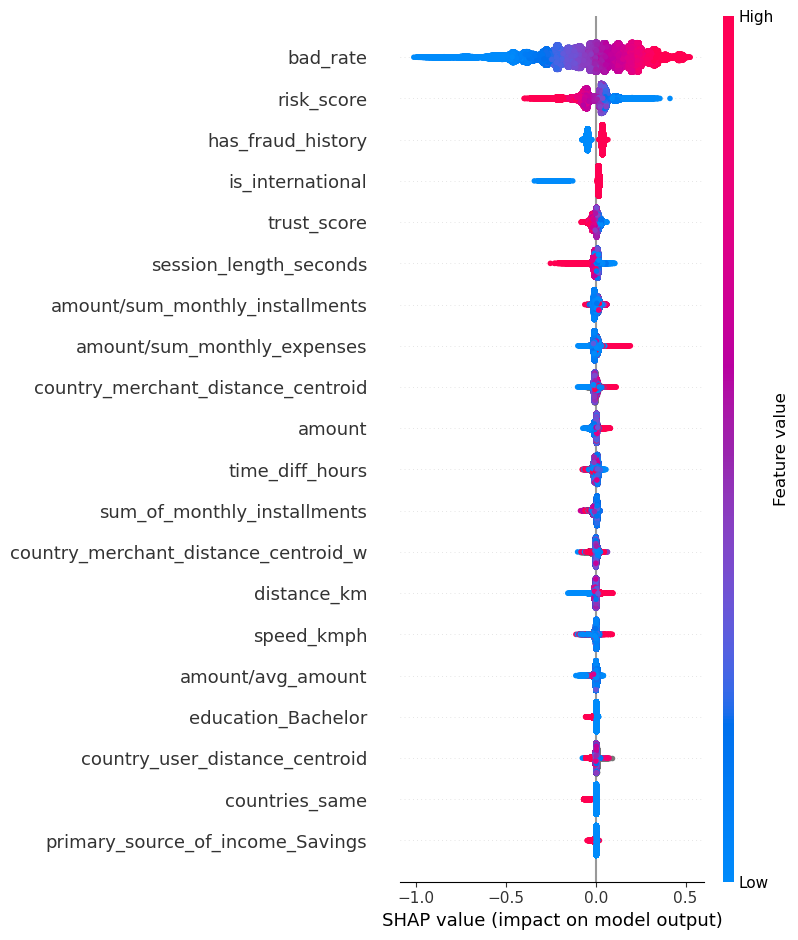

In [41]:

# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test)


In [42]:

# 4. Identify top 3 most important features
shap_importance = np.abs(shap_values.values).mean(axis=0)
top3_features = X_train.columns[np.argsort(shap_importance)[-3:][::-1]].tolist()
print("Top 3 features based on SHAP:", top3_features)

Top 3 features based on SHAP: ['bad_rate', 'risk_score', 'has_fraud_history']


In [43]:
top3_features = ['bad_rate','trust_score','risk_score', 'amount/sum_monthly_installments', 'sum_of_monthly_installments']

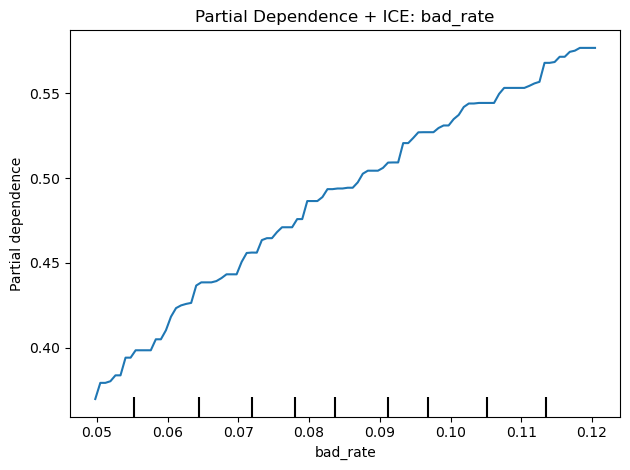

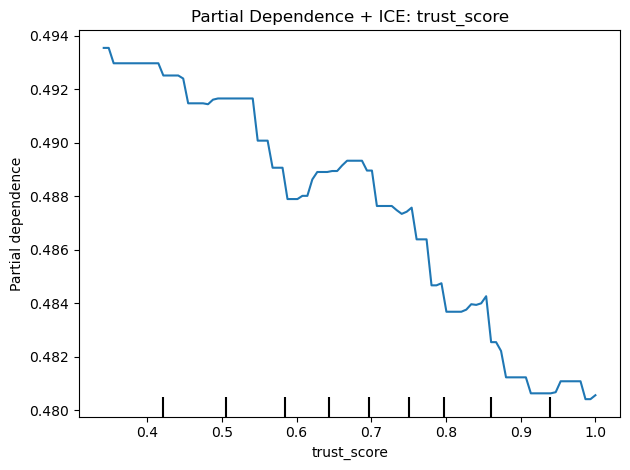

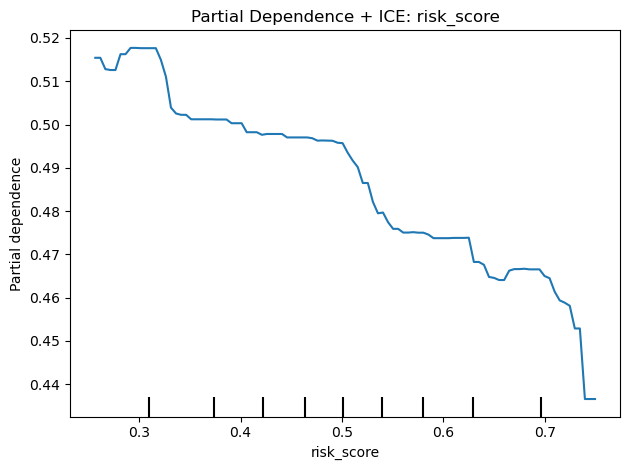

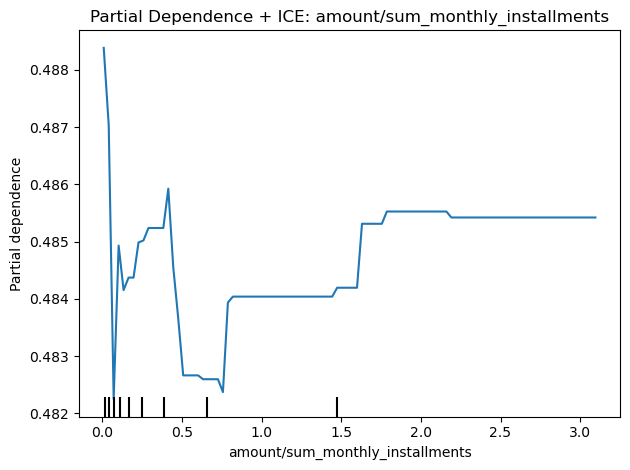

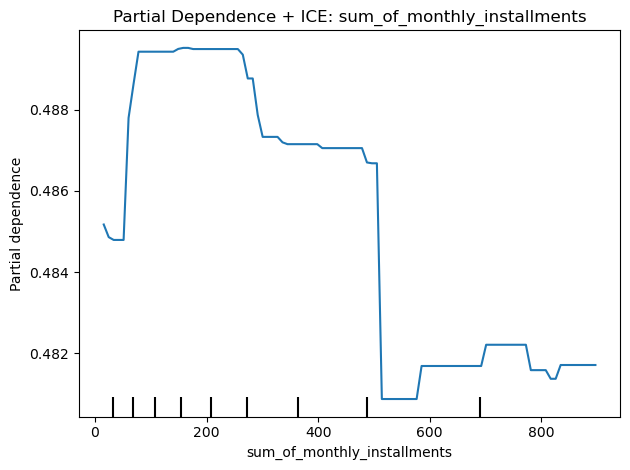

In [44]:

for feature in top3_features:
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        [feature],          # must be a list
        # kind='both',        # PDP + ICE curves
        # grid_resolution=30, # smoother curves
        # subsample=100,      # limit ICE lines to 100 samples
        random_state=42     # for reproducibility
    )
    plt.title(f'Partial Dependence + ICE: {feature}')
    plt.tight_layout()
    plt.show()

In [45]:

# 6. Permutation Importance
perm = permutation_importance(model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("Permutation Importance:")
print(perm_df.head(10))

Permutation Importance:
                             feature  importance_mean  importance_std
139                         bad_rate         0.059437        0.003709
12                        risk_score         0.007913        0.000662
1                   is_international         0.002964        0.000461
8                  has_fraud_history         0.000729        0.000569
4                        trust_score         0.000488        0.000200
25   amount/sum_monthly_installments         0.000156        0.000234
27                    countries_same         0.000137        0.000094
131        transaction_country_Spain         0.000125        0.000138
10       sum_of_monthly_installments         0.000118        0.000193
19                       country_m=t         0.000100        0.000027
